# Assignment 1

In this Assignment we  define and train an Autoencoder. This Autoencoder encodes a one-hot-encoded vector of shape $ \mathsf{R}^{1\times8} $ into a compressed space pof shape $ \mathsf{R}^{1\times3} $ then decodes it back into the original shape $ \mathsf{R}^{1\times8} $.
Additionally, we implement the backpropagation algorithm and compare batch gradient descent with stochastic or mini-batch gradient descent with different hyperparameters.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

We chose numpy arrays for the Weights of Network to utilize the fast Vector Operations build into numpy. We the then decided to store the different layer weights into a list instead of stacking them into a larger numpy ndarray because doing that makes things more complicated.

In [16]:
# Initialize Network
def initializeNetworkWeights(scale=0.01):
    W = [np.random.random((3, 8)), np.random.random((8, 3))]
    W = [(x - np.ones(x.shape) * 0.5) * scale for x in W]
    b = [np.random.random(3), np.random.random(8)]
    b = [(x - np.ones(x.shape) * 0.5) * scale for x in b]
    return W, b


We chose to use the sigmoid function as our activation function and the half sum squared as our error. Alternatives could have been using tanh as an activation function and the cross entropy loss as the error. For the cross entropy loss you would then also have to use the softmax activation function in the output layer.

In [17]:
# Useful functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoidPrime(x):
    return sigmoid(x) * (1 - sigmoid(x))


def half_sum_squared(X, Y):
    return np.linalg.norm(X - Y) ** 2 / 2


def forward(X, W, b):
    """
    
    :return: the final output and the z's of the layers after the input
    """
    a = X
    z_list = []
    for w, b in zip(W, b):
        z = np.matmul(w, a.T).T + b
        z_list.append(z)
        a = sigmoid(z)
    return a, z_list


Next we get the contribution of the specific weights in each layer to the final error, also called delta's. And then update the original weights in the network using the average over the provided batch.

In [18]:

# Getting Deltas
def getDeltas(z_list, Y, W):
    delta_list = []
    for i in reversed(range(len(z_list))):
        if i == len(z_list) - 1:
            z = z_list[i]
            a = sigmoid(z)
            delta = -(Y - a) * sigmoidPrime(z)
            delta_list.append(delta)
        else:
            z = z_list[i]
            delta = np.matmul(delta_list[len(delta_list) - 1], W[i + 1]) * sigmoidPrime(z)
            # delta = np.matmul(W[i + 1].T, delta_list[len(delta_list) - 1]).T*sigmoidPrime(z)
            delta_list.append(delta)
    return delta_list


# Backpropagate
def backprop(X, Y, W, b, learning_rate=0.03, weightDecay=0.01):
    a, zlist = forward(X, W, b)
    delta_list = getDeltas(zlist, Y, W)
    # Dont average here!!
    # delta_list = [np.average(x, axis=0) for x in delta_list]
    delta_list = list(reversed(delta_list))
    a_list = [sigmoid(x) for x in zlist]
    a_list.insert(0, np.array(X))
    a_list = [x.reshape(x.shape[0], 1, x.shape[1]) for x in a_list]
    delta_list = [x.reshape(x.shape[0], x.shape[1], 1) for x in delta_list]
    for i in range(len(delta_list)):
        derivativeW = a_list[i] * delta_list[i]
        derivativeW = np.average(derivativeW, axis=0)
        # Average here!!
        W[i] = W[i] - learning_rate * derivativeW - W[i] * (weightDecay / len(X))
        b[i] = b[i] - learning_rate * np.average(delta_list[i], axis=0).reshape(-1)
    return W, b

Next we define two different Functions combining everything we defined above into the actual gradient descent algorithm. For that we differentiate between a whole batch gradient descent and the stochastic or mini batch gradient descent.

In [19]:
# Batch Gradient Descent
def batch_GD(X, Y, epoch=20000, learning_rate=0.003, weightDecay=0.1, scale=0.1):
    W, b = initializeNetworkWeights(scale)
    print(W)
    print(b)
    a, zlist = forward(X, W, b)
    print(a)
    for i in range(epoch):
        W, b = backprop(np.copy(X), Y, W, b, learning_rate, weightDecay)
        a, z_list = forward(X, W, b)
        # print(a)
        # print(half_sum_squared(a, Y))
    return W, b


# Batch Gradient Descent
def stochastic_or_mini_batch_GD(X, Y, epoch=20000, learning_rate=0.003, weightDecay=0.01, scale=0.1, sample_size=1):
    """
        Pick a sample size of 1 for stochastic GD, if the sample size is equal to the length of the whole dataset this is equal to the batch GD
    """
    W, b = initializeNetworkWeights(scale)

    # print(W)
    # print(b)
    a, zlist = forward(X, W, b)
    # print(a)
    for i in range(epoch):
        random_indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
        W, b = backprop(X[random_indices], Y[random_indices], W, b, learning_rate, weightDecay)
        a, z_list = forward(X, W, b)
        # print(a)
        # print(half_sum_squared(a, Y))
    return W, b



## Experiments
First define the different Parameters we want to test.

In [20]:
random_scales = [0.01, 0.1, 5]
learning_rates = [0.03, 0.3, 3]
weight_decays = [0.003, 0.03, 0.3]
epochs = [20, 200, 2000,20000,200000]
sample_sizes = [1, 3, 5, 8]

Next to the half sum squared error we also want to know the accuracy of the network, for that we take the argmax of the networks output and compare it to the orignal data.

In [21]:
def accuracy(a, Y):
    y_pred = np.argmax(a, axis=1)
    Y_true = np.argmax(Y, axis=1)
    TP = np.sum(y_pred == Y_true)
    return TP / len(Y)



Then we gather our data for each combination of hyper parameters and safe them in a list.

In [ ]:
results = []
X = np.zeros((8, 8))
for i in range(8):
    X[i, i] = 1
Y = np.array(X)
for scale in random_scales:
    result_scale = []
    for learning_rate in learning_rates:
        result_learning_rate = []
        for weight_decay in weight_decays:
            result_weight_decay_ = []
            for sample in sample_sizes:
                result_sample = []
                for epoch in epochs:
                    W, b = initializeNetworkWeights(scale)
                    W, b = stochastic_or_mini_batch_GD(X, Y, epoch=epoch, learning_rate=learning_rate, weightDecay=weight_decay, scale=scale)
                    a, zlist = forward(X, W, b)
                    half_sum_squared_error = half_sum_squared(a, Y)
                    accuracy_error = accuracy(a, Y)
                    result_sample.append([accuracy_error,half_sum_squared_error])
                result_weight_decay_.append(result_sample)
            result_learning_rate.append(result_weight_decay_)
        result_scale.append(result_learning_rate)
    results.append(result_scale)


And now we will need to visualize the results. For that we create 27 Plots with the $ \verb|random_scale|$, $ \verb|learning_rate|$ and $ \verb|weight_decay|$ fixed.

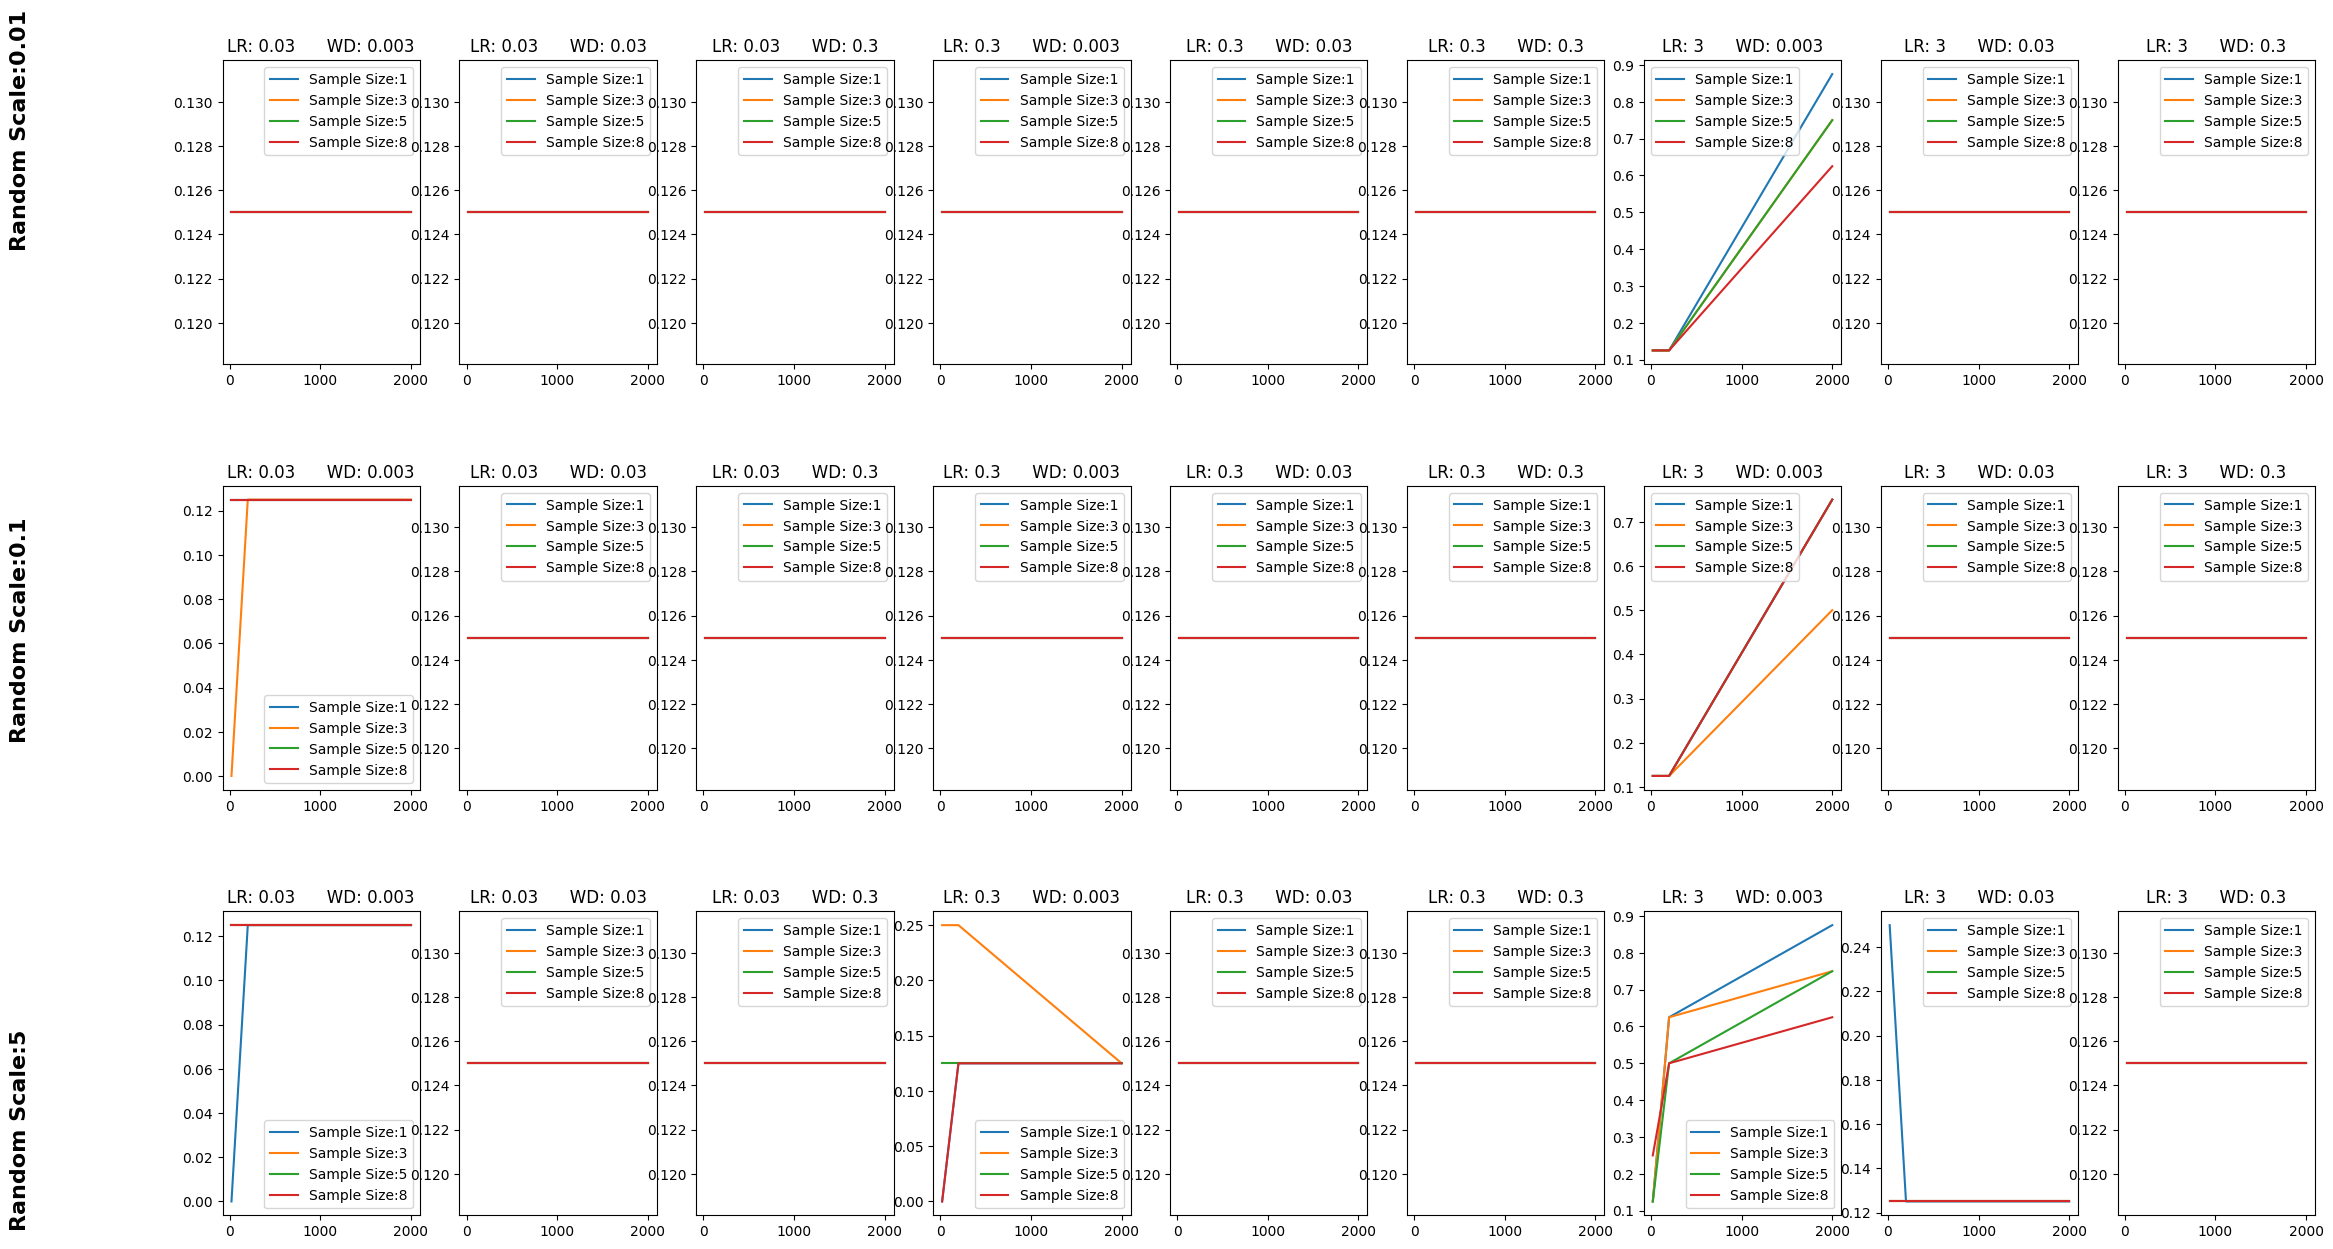

In [14]:
import math
fig, axes = plt.subplots(3, 9,figsize=(27,15))
fig.subplots_adjust(hspace=0.4)
for i in range(3):
    title = f"Random Scale:{random_scales[i]}"
    y_coord = 1 - (i + 0.5) / 3
    fig.text(0.05, y_coord, title, va='center', ha='center', fontsize=16, weight='bold', rotation=90)
    for j in range(9):
        learning_rate_index = int(j / 3)
        weight_decay_index = int(j % 3)
        unique_title = f"LR: {learning_rates[learning_rate_index]}      WD: {weight_decays[weight_decay_index]}"
        axes[i][j].set_title(unique_title)
        result = results[i][learning_rate_index][weight_decay_index]
        for k in range(len(sample_sizes)):
            sample_size_result = result[k]
            axes[i][j].plot(epochs, np.array(sample_size_result)[:,0], label=f"Sample Size:{sample_sizes[k]}")
        axes[i][j].legend()
plt.show()


